# VQA model accuracy

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import re, sys
import os
import copy
import io
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load VizWiz test set data**

In [2]:
with open('/media/arnau/PEN/TFG/hf_model_test_res.json', encoding='UTF-8') as jf:
    model_output_data = json.load(jf)

## PromptCap accuracy
PromptCap model accuracy evaluated on VizWiz test set

In [3]:
import torch
from promptcap import PromptCap

model = PromptCap("vqascore/promptcap-coco-vqa")  # also support OFA checkpoints. e.g. "OFA-Sys/ofa-large"

if torch.cuda.is_available():
    model.cuda()

vqascore/promptcap-coco-vqa
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/home/arnau/tfg/GED-TFG/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Helper functions

In [4]:
def remove_periods(q):
    
    outText = q
    puncts = [';', r"/", '[', ']', '"', '{', '}',
                                 '(', ')', '=', '+', '\\', '_', '-',
                                 '>', '<', '@', '`', ',', '?', '!']
    comma_strip = re.compile("(\d)(\,)(\d)")
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    for p in puncts:
        if (p + ' ' in q or ' ' + p in q) or (re.search(comma_strip, q) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            outText = periodStrip.sub("",
                                           outText,
                                           re.UNICODE)
    return outText

In [5]:


def num_words_to_digit(q):
    
    outText = []
    tempText = q.lower().split()
    manualMap  = { 'none': '0',
                    'zero': '0',
                    'one': '1',
                     'two': '2',
                     'three': '3',
                     'four': '4',
                     'five': '5',
                     'six': '6',
                     'seven': '7',
                     'eight': '8',
                     'nine': '9',
                     'ten': '10'}
    articles     = ['a',
                             'an',
                             'the'
                    ]
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                            "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                            "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                            "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                            "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                            "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                            "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                            "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                            "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                            "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                            "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                            "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                            "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                            "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                            "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                            "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                            "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                            "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                            "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                            "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                            "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                            "youll": "you'll", "youre": "you're", "youve": "you've"
                            }
    for word in tempText:
        word = manualMap.setdefault(word, word)
        if word not in articles:
            outText.append(word)
        else:
            pass

    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [6]:
def updateProgress(progress):
    
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rFinshed Percent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), int(progress*100), status)
    sys.stdout.write(text)
    sys.stdout.flush()

### Evaluation

In [7]:
def evaluate_acc_promptcap(model_output_data, model_type):
    """ 
    Calculates accuracy metric for VQA model
    """
    
    accQA       = []
    step = 0
    
    data = model_output_data.copy()
    
    for img, img_info in data.items():
        question = img_info["question"]
        gtanswers = img_info["gt_answers"]
        for ans in gtanswers:
            if type(ans['answer']) == str:
                ans['answer'] = ans['answer'].replace('\n', ' ').replace('\t', ' ').strip().lower()
            else:
                ans['answer'] = ' '.join(ans['answer'])
        resAns = img_info[model_type]
        if resAns:
            resAns = resAns.replace('\n', ' ')
            resAns = resAns.replace('\t', ' ')
            resAns = resAns.strip()
            resAns = resAns.lower()
        else:
            resAns = ''
        gtAcc = []
        gtAnswers = [ans["answer"] for ans in gtanswers]

        if len(set(gtAnswers)) > 1:
            for ans in gtanswers:
                if type(ans['answer']) == str:
                    ans["answer"] = remove_periods(ans['answer'])
                    ans["answer"] = num_words_to_digit(ans['answer'])
                else:
                    ans["answer"] = remove_periods(' '.join(ans['answer']))
                    ans["answer"] = num_words_to_digit(' '.join(ans['answer']))
            resAns = remove_periods(resAns)
            resAns = num_words_to_digit(resAns)

        for ans in gtanswers:
            # otherGTAns = [item for item in gtanswers if item!=ans]
            matchingAns = [ans for ans in gtanswers if ans['answer'] == resAns]
            acc = min(1, float(len(matchingAns))/3)
            gtAcc.append(acc)

        avgGTAcc = float(sum(gtAcc))/len(gtAcc)
        accQA.append(avgGTAcc)

        if step%100 == 0:
            updateProgress(step/float(len(data.keys())))
        step = step + 1
    
    return accQA


In [8]:
model_types = [
                "HF_OCR_google_answer",
                "HF_OCR_answer",
                "HF_NON_OCR_answer"
                ]
default_results = []
for typ in model_types:
    res = evaluate_acc_promptcap(model_output_data, typ)
    acc = (sum(res) / len(res)) * 100
    default_results.append((typ, acc))
    print(f"--> {typ}: {acc:.4f}%")

Finshed Percent: [###################-] 93% --> HF_OCR_google_answer: 8.6062%
Finshed Percent: [###################-] 93% --> HF_OCR_answer: 7.0159%
Finshed Percent: [###################-] 93% --> HF_NON_OCR_answer: 10.6330%


## PromptCap accuracy using Blur model

PromptCap accuracy evaluted on VizWiz test set with a prior filtering of blurred images using a custom blur detection model

In [9]:
def model_inference(img, model_params):
    """
    Returns 1 if the input image is blurred otherwise returns 0
    """
    
    model, device, thr = model_params
        
    trnsfm = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4550, 0.4196, 0.3736], [0.2908, 0.2805, 0.2861])
    ])
    }
    
    model.eval()
    
    if type(img) == str:
        test_path = '/media/arnau/PEN/TFG/val/'
        img_path = os.path.join(test_path, img)
        img = Image.open(img_path)

    img = trnsfm["val"](img)
    img = img[None, :, :, :] 
    img = img.to(device)
    outputs = model(img)
    
    pred = torch.sigmoid(outputs.data).cpu().detach().numpy().tolist()[0][0]
    pred_res = 1 if float(pred) > float(thr) else 0
    
    return pred_res


In [10]:
def initialize_model():
    """
    Initializes the blur model
    """
    
    # GPU device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.add_module("dropout", nn.Dropout(0.04653))
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, 1)
    
    # Load custom blur model
    save_path = '../outputs/best.pth'
    model.load_state_dict(torch.load(save_path))
    model = model.to(device)
    
    return model

In [11]:
def get_clear_images(model_output_data, model_params):
    """
    Given a dataset of images, returns a filtered array where the blurred images
    have been removed
    """
    
    clear_images = {}
    
    for img, img_info in model_output_data.items():
        # Blur model filter
        blur_detection = model_inference(img, model_params)
        if not blur_detection:
            clear_images[img] = img_info
            
    return clear_images
 
    
def percent_imgs_rejected(og_data, filt_data):
    imgs_rejected = len(og_data.keys()) - len(filt_data.keys())
    
    if float(imgs_rejected) == 0.0:
        p_imgs_rejected = 0.0
        
    p_imgs_rejected = imgs_rejected / len(og_data.keys())
        
    return p_imgs_rejected * 100
    

In [12]:
model = initialize_model()

model_params = (model, device)

In [13]:
data = {"model_type": [],
        "rej_rate": [], 
        "p_imgs_rej": [],
      "acc": []}

In [14]:
blur_results = []
rej_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# For every rejection rate, compares the default model (rej_rates = 0.0) with 
for rr in rej_rates:
    if rr == 0.0:
        filtered_data = model_output_data  # Default model (no rejecting images)
    else:
        filtered_data = get_clear_images(model_output_data, (model, device, rr))
    for typ in model_types:
        res = evaluate_acc_promptcap(filtered_data, typ)
        p_imgs_rej = percent_imgs_rejected(model_output_data, filtered_data)
        acc = (sum(res) / len(res)) * 100
        blur_results.append((typ, acc))
        #print(f"--> {typ}: {acc:.4f}%")
        data["model_type"].append(typ)
        data["acc"].append(acc)
        data["rej_rate"].append(rr)
        data["p_imgs_rej"].append(p_imgs_rej)

Finshed Percent: [##################--] 87% 

**Visualization** 

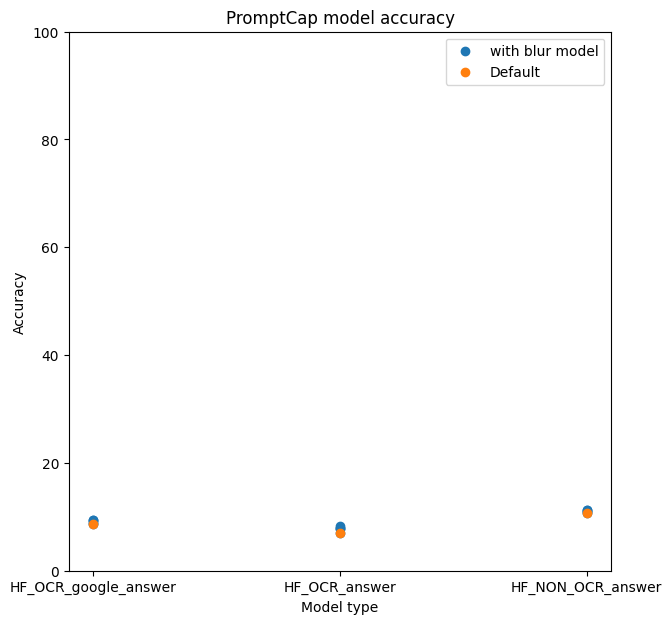

In [15]:
plt.figure(figsize=(7, 7))
plt.scatter(list(np.asarray(blur_results)[:, 0]), np.array(np.asarray(blur_results)[:, 1], dtype=np.float32), label="with blur model")
plt.scatter(list(np.asarray(default_results)[:, 0]), np.array(np.asarray(default_results)[:, 1], dtype=np.float32), label="Default")
plt.ylim([0, 100])
plt.title("PromptCap model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model type")
plt.legend()
plt.show()

In [16]:
df = pd.DataFrame.from_dict(data)

In [17]:
df

,model_type,rej_rate,p_imgs_rej,acc
0,HF_OCR_google_answer,0.0,0.000000,8.606174
1,HF_OCR_answer,0.0,0.000000,7.015903
2,HF_NON_OCR_answer,0.0,0.000000,10.632990
3,HF_OCR_google_answer,0.2,41.534144,8.800000
4,HF_OCR_answer,0.2,41.534144,7.946667
5,HF_NON_OCR_answer,0.2,41.534144,10.826667
6,HF_OCR_google_answer,0.4,36.389149,9.362745
7,HF_OCR_answer,0.4,36.389149,8.235294
8,HF_NON_OCR_answer,0.4,36.389149,11.176471
9,HF_OCR_google_answer,0.6,30.963517,9.304426


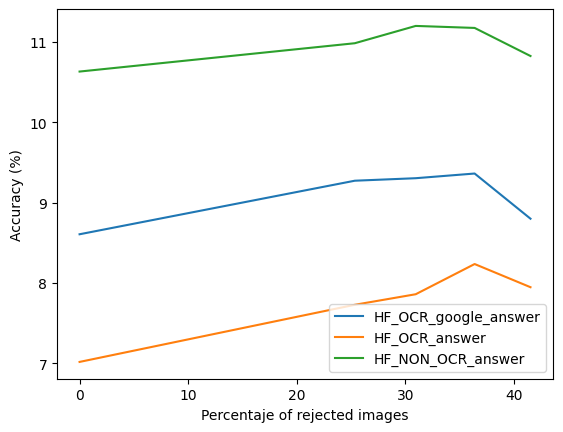

In [36]:
for typ in model_types:
    data = df[df["model_type"] == typ].sort_values('p_imgs_rej')
    plt.plot(data["p_imgs_rej"].tolist(),
            data["acc"].tolist(), label=typ)
    plt.legend(loc=4)
    plt.xlabel("Percentaje of rejected images")
    plt.ylabel("Accuracy (%)")
plt.show()